# **NutriVision**: Food Detection And Nutrition Analysis Project

We developed an intelligent food recognition system that can identify 50 different types of food from photographs and instantly report their nutritional information. The system uses two advanced artificial intelligence models; MobileNetV2 and EfficientNetB0, that were initially trained on millions of images and then specialized to recognize specific foods like pizza, sushi, hamburgers, and salads. After analyzing over 37,500 training images, our best model achieved 72% accuracy in correctly identifying foods from new photographs it had never seen before. Once a food item is identified, the system automatically looks up and displays detailed nutritional data including calories, protein, fat, and carbohydrates per 100 grams. This project demonstrates a complete workflow from data preparation to training, evaluation, and deployment that supports practical applications such as diet tracking and health-focused food analysis. This technology could be valuable for health-conscious individuals, dietitians, and anyone interested in tracking their nutritional intake through simple smartphone photography.

In [ ]:
# ==============================================================================
#  FOOD DETECTION - 50 CLASS: TRAIN + VISUALIZE
# ==============================================================================

"""
Focus: Environment setup and nutrition database.

This cell prepares the runtime environment for the notebook: it installs a small
keep-alive snippet (useful for Google Colab), configures basic TensorFlow thread
settings, enables GPU memory growth (if GPUs are present), mounts Google Drive,
and defines the `NUTRITION_DB` lookup dictionary used by the inference/visualiza-
tion cells later in the notebook.
"""

# Colab keep-alive: clicks the connect button every 60 seconds to reduce
# accidental disconnections during long runs (only runs when executed inside
# Google Colab). This is purely optional but helpful for long training or eval.
from IPython.display import Javascript, display

display(
    Javascript(
        """
function KeepClicking(){
   console.log("Keeping connection alive");
   document.querySelector("colab-connect-button")?.click();
}
setInterval(KeepClicking, 60000);
"""
    )
)

# Environment tuning for TensorFlow threading. These variables can be adjusted
# to match the hardware and workload. They are string values required by TensorFlow (TF).
import os
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"

# TensorFlow and Keras imports. `preprocess_input` for MobileNetV2 is imported
# here because later cells will use backbone-specific preprocessing.
import random
import shutil
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

print("=" * 60)
print("FOOD DETECTION - 50 CLASSES WITH VISUALIZATION")
print("=" * 60)

# If a GPU is available, enable memory growth so TensorFlow allocates memory
# on demand instead of pre-allocating all GPU memory. Safe to run even if no
# GPU exists.
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Mount Google Drive (Colab). This allows saving/loading large datasets and
# model artifacts directly to the user's Drive. If not running in Colab,
# this line will raise an error and can be removed.
from google.colab import drive  # noqa: E402 (import after top-level TF init)

drive.mount("/content/drive")

# Standard Python utilities used in the cell and nearby cells. These imports
# are placed near the top for clarity and to satisfy linters.
import json  # noqa: E402 (kept with other local imports for readability)

# -----------------------------------------------------------------------------
# Nutrition lookup table
#
# `NUTRITION_DB` maps the normalized food key to a per-100g
# nutrition breakdown used by the visualization and web demo. Values are plain
# integers (or small ints) representing kcal and grams.
#
# NOTE: This dictionary is intentionally self-contained and small to make it
# easy to inspect and modify while developing or presenting results.
# -----------------------------------------------------------------------------
NUTRITION_DB = {
    "pizza": {"calories": 266, "protein": 11, "fat": 10, "carbs": 33},
    "hamburger": {"calories": 354, "protein": 17, "fat": 17, "carbs": 35},
    "sushi": {"calories": 143, "protein": 6, "fat": 4, "carbs": 21},
    "ice_cream": {"calories": 207, "protein": 4, "fat": 11, "carbs": 24},
    "french_fries": {"calories": 312, "protein": 4, "fat": 15, "carbs": 41},
    "donuts": {"calories": 269, "protein": 4, "fat": 13, "carbs": 33},
    "apple_pie": {"calories": 237, "protein": 2, "fat": 11, "carbs": 34},
    "chocolate_cake": {"calories": 352, "protein": 5, "fat": 14, "carbs": 52},
    "hot_dog": {"calories": 290, "protein": 10, "fat": 18, "carbs": 22},
    "pancakes": {"calories": 227, "protein": 6, "fat": 10, "carbs": 28},
    "tacos": {"calories": 226, "protein": 10, "fat": 12, "carbs": 20},
    "spaghetti_bolognese": {"calories": 350, "protein": 12, "fat": 14, "carbs": 45},
    "chicken_wings": {"calories": 290, "protein": 23, "fat": 19, "carbs": 5},
    "fried_rice": {"calories": 228, "protein": 4, "fat": 11, "carbs": 29},
    "nachos": {"calories": 346, "protein": 7, "fat": 19, "carbs": 36},
    "waffles": {"calories": 291, "protein": 6, "fat": 13, "carbs": 37},
    "grilled_cheese_sandwich": {"calories": 440, "protein": 18, "fat": 26, "carbs": 33},
    "lasagna": {"calories": 378, "protein": 15, "fat": 18, "carbs": 38},
    "macaroni_and_cheese": {"calories": 320, "protein": 11, "fat": 15, "carbs": 36},
    "cheesecake": {"calories": 321, "protein": 6, "fat": 23, "carbs": 26},
    "tiramisu": {"calories": 240, "protein": 5, "fat": 13, "carbs": 26},
    "french_toast": {"calories": 220, "protein": 8, "fat": 10, "carbs": 25},
    "omelette": {"calories": 154, "protein": 11, "fat": 12, "carbs": 1},
    "eggs_benedict": {"calories": 450, "protein": 18, "fat": 32, "carbs": 20},
    "caesar_salad": {"calories": 184, "protein": 8, "fat": 14, "carbs": 6},
    "greek_salad": {"calories": 106, "protein": 3, "fat": 8, "carbs": 6},
    "caprese_salad": {"calories": 108, "protein": 6, "fat": 7, "carbs": 4},
    "clam_chowder": {"calories": 236, "protein": 8, "fat": 17, "carbs": 14},
    "miso_soup": {"calories": 40, "protein": 2, "fat": 1, "carbs": 5},
    "ramen": {"calories": 436, "protein": 13, "fat": 16, "carbs": 59},
    "pad_thai": {"calories": 380, "protein": 12, "fat": 14, "carbs": 50},
    "spring_rolls": {"calories": 140, "protein": 4, "fat": 5, "carbs": 20},
    "samosa": {"calories": 262, "protein": 5, "fat": 16, "carbs": 25},
    "gyoza": {"calories": 64, "protein": 3, "fat": 2, "carbs": 8},
    "dumplings": {"calories": 41, "protein": 2, "fat": 1, "carbs": 6},
    "beef_tartare": {"calories": 180, "protein": 20, "fat": 11, "carbs": 0},
    "ceviche": {"calories": 120, "protein": 18, "fat": 3, "carbs": 6},
    "bruschetta": {"calories": 109, "protein": 3, "fat": 5, "carbs": 13},
    "hummus": {"calories": 166, "protein": 8, "fat": 10, "carbs": 14},
    "guacamole": {"calories": 150, "protein": 2, "fat": 14, "carbs": 8},
    "fish_and_chips": {"calories": 585, "protein": 25, "fat": 34, "carbs": 44},
    "chicken_curry": {"calories": 250, "protein": 18, "fat": 15, "carbs": 12},
    "steak": {"calories": 271, "protein": 25, "fat": 19, "carbs": 0},
    "pork_chop": {"calories": 231, "protein": 23, "fat": 15, "carbs": 0},
    "lobster_bisque": {"calories": 200, "protein": 8, "fat": 15, "carbs": 8},
    "scallops": {"calories": 137, "protein": 24, "fat": 2, "carbs": 6},
    "oysters": {"calories": 68, "protein": 7, "fat": 2, "carbs": 4},
    "red_velvet_cake": {"calories": 478, "protein": 5, "fat": 21, "carbs": 68},
    "carrot_cake": {"calories": 435, "protein": 5, "fat": 21, "carbs": 58},
    "bread_pudding": {"calories": 310, "protein": 7, "fat": 13, "carbs": 42},
}


<IPython.core.display.Javascript object>

FOOD DETECTION - 50 CLASSES WITH VISUALIZATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Load dataset -------------------------------------------------------------
from pathlib import Path
import random
import shutil
from typing import List

import kagglehub

# Download dataset via kagglehub and locate key folders.
kaggle_path = kagglehub.dataset_download("dansbecker/food-101")
kaggle_base = Path(kaggle_path)

# Locate the images and meta directories in the downloaded dataset.
IMAGES_DIR = next(kaggle_base.rglob("images"))
SOURCE_META = next(kaggle_base.rglob("meta"))

# Upload / copy meta to Google Drive (path is used later by other cells).
DEST_META = Path("/content/drive/MyDrive/AAI521-Final-Project/data/food-101/meta")
if not DEST_META.exists():
    DEST_META.parent.mkdir(parents=True, exist_ok=True)
    shutil.copytree(SOURCE_META, DEST_META)

META_DIR = DEST_META
SAVE_DIR = Path("/content/drive/MyDrive/AAI521-Final-Project/outputs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Training constants.
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Use a curated list of 50 classes from Food-101.
SELECTED_CLASSES = [
    "pizza", "hamburger", "sushi", "ice_cream", "french_fries", "donuts",
    "apple_pie", "chocolate_cake", "hot_dog", "pancakes", "tacos",
    "spaghetti_bolognese", "chicken_wings", "fried_rice", "nachos",
    "waffles", "grilled_cheese_sandwich", "lasagna",
    "macaroni_and_cheese", "cheesecake", "tiramisu", "french_toast",
    "omelette", "eggs_benedict", "caesar_salad", "greek_salad",
    "caprese_salad", "clam_chowder", "miso_soup", "ramen", "pad_thai",
    "spring_rolls", "samosa", "gyoza", "dumplings", "beef_tartare",
    "ceviche", "bruschetta", "hummus", "guacamole", "fish_and_chips",
    "chicken_curry", "steak", "pork_chop", "lobster_bisque", "scallops",
    "oysters", "red_velvet_cake", "carrot_cake", "bread_pudding",
]

# Mapping from class name -> integer label.
class_to_idx = {c: i for i, c in enumerate(SELECTED_CLASSES)}


# --- Load data ----------------------------------------------------------------
def read_list(path: Path) -> List[str]:
    """Read lines from a text file and return non-empty stripped lines.

    Parameters
    ----------
    path : Path
        Path to the text file to read.

    Returns
    -------
    List[str]
        List of non-empty, stripped lines.
    """
    with path.open("r", encoding="utf-8") as handle:
        return [line.strip() for line in handle if line.strip()]


# Read train / test meta lists and filter to the selected classes.
all_train = read_list(META_DIR / "train.txt")
all_test = read_list(META_DIR / "test.txt")

train_list = [
    line for line in all_train if line.split("/", 1)[0] in SELECTED_CLASSES
]
test_list = [
    line for line in all_test if line.split("/", 1)[0] in SELECTED_CLASSES
]

# Shuffle training list to prevent order bias during dataset creation.
random.shuffle(train_list)


Using Colab cache for faster access to the 'food-101' dataset.


In [ ]:
"""
Functions and dataset pipelines for converting meta file entries into
(path, label) pairs and building TensorFlow input pipelines. This cell
focuses only on preparing image paths, labels, and tf.data datasets.
"""

from typing import List, Tuple

import tensorflow as tf


def create_pairs(file_list: List[str]) -> List[Tuple[str, int]]:
    """Convert dataset file stems into full image paths and labels.

    Each entry in the input list is of the form "class_name/image_id".
    This function expands it into:
        ("/full/path/to/class_name/image_id.jpg", label_index)

    Parameters
    ----------
    file_list : List[str]
        List of dataset stems in the format "class/img_id".

    Returns
    -------
    List[Tuple[str, int]]
        A list of (path, label) pairs.
    """
    pairs = []
    for stem in file_list:
        cls, base = stem.split("/", 1)
        if cls not in SELECTED_CLASSES:
            continue

        img_path = str(IMAGES_DIR / cls / f"{base}.jpg")
        label = class_to_idx[cls]
        pairs.append((img_path, label))

    return pairs


# Create (path, label) pairs for train and test sets.
train_pairs = create_pairs(train_list)
test_pairs = create_pairs(test_list)

random.shuffle(train_pairs)


def decode_resize(path: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Load, decode, resize, and preprocess an image for model input.

    Parameters
    ----------
    path : tf.Tensor
        Tensor containing image file path.
    label : tf.Tensor
        Tensor containing the numeric class label.

    Returns
    -------
    Tuple[tf.Tensor, tf.Tensor]
        Preprocessed (image_tensor, label).
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label


# Unpack image paths and labels.
train_paths, train_labels = zip(*train_pairs)
test_paths, test_labels = zip(*test_pairs)

# Build training pipeline with shuffling and prefetching.
train_ds = (
    tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_labels)))
    .shuffle(buffer_size=len(train_pairs))
    .map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Build test pipeline (shuffle not needed).
test_ds = (
    tf.data.Dataset.from_tensor_slices((list(test_paths), list(test_labels)))
    .map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
"""
Model construction cell using MobileNetV2 as the feature extractor and a
custom classification head. This cell focuses solely on building and
compiling the model following PEP8 style guidelines.
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2


# Build model ---------------------------------------------------------------

# Input layer for 224×224 RGB images.
inputs = layers.Input(shape=(224, 224, 3))

# Base model (frozen) using MobileNetV2 pretrained on ImageNet.
base = MobileNetV2(include_top=False, weights="imagenet")
base.trainable = False

# Pass inputs through the base network.
x = base(inputs)

# Classification head.
x = layers.GlobalAveragePooling2D()(x)

# First dense block.
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Second dense block.
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer for 50 classes.
outputs = layers.Dense(50, activation="softmax")(x)

# Assemble model.
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model.
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("Model ready\n")


/tmp/ipython-input-1186442441.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet')


Model ready



In [ ]:
"""
Training and evaluation cell for the 50-class food classification model.
Executes model fitting, evaluation, and saving of outputs following PEP8
style guidelines.
"""

from tensorflow.keras.callbacks import ModelCheckpoint
import json


# Train -----------------------------------------------------------------------

print("=" * 60)
print("TRAINING")
print("=" * 60 + "\n")

callbacks = [
    ModelCheckpoint(
        filepath=str(SAVE_DIR / "model_50class.keras"),
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate --------------------------------------------------------------------

results = model.evaluate(test_ds, verbose=0)
loss, accuracy = results

print("\n" + "=" * 60)
print("FINAL TRAINING RESULTS")
print("=" * 60)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}\n")

# Save model and nutrition data ----------------------------------------------

model.save(SAVE_DIR / "final_model_50class.keras")

with open(SAVE_DIR / "nutrition_database.json", "w") as f:
    json.dump(NUTRITION_DB, f, indent=2)


TRAINING

Epoch 1/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3756 - loss: 2.4650
Epoch 1: val_accuracy improved from -inf to 0.65240, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 93s 55ms/step - accuracy: 0.3757 - loss: 2.4646 - val_accuracy: 0.6524 - val_loss: 1.2088
Epoch 2/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5653 - loss: 1.5710
Epoch 2: val_accuracy improved from 0.65240 to 0.67616, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5653 - loss: 1.5710 - val_accuracy: 0.6762 - val_loss: 1.1280
Epoch 3/20
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6039 - loss: 1.4271
Epoch 3: val_accuracy improved from 0.67616 to 0.68024, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accur

In [ ]:
"""
Visualization helpers for food classification results.

This section contains utility functions used to select random example images
and to run the model prediction pipeline to produce display images and
prediction + nutrition results.
"""

from typing import Any, Dict, List, Optional, Tuple

# ==============================================================================
# VISUALIZATION SECTION
# ==============================================================================
print("\n" + "=" * 60)
print("CREATING VISUALIZATIONS")
print("=" * 60 + "\n")


def get_random_image(food_class: str) -> Tuple[Optional[Any], Optional[str]]:
    """
    Get a random image for a given food class.

    This function searches the directory for the specified `food_class`
    beneath the pre-defined `IMAGES_DIR`, selects a random JPEG image if any
    exist, decodes and resizes it to the model input size (224x224), and
    returns a NumPy-compatible image array (uint8) together with the image
    path as a string.

    Parameters
    ----------
    food_class : str
        Name of the food class (subdirectory name under IMAGES_DIR).

    Returns
    -------
    tuple
        A tuple (image_array, image_path). If no image is found, both
        elements will be None. The `image_array` is the decoded and resized
        image (uint8), and `image_path` is the string path to the chosen
        image file.
    """
    class_dir = IMAGES_DIR / food_class
    images = list(class_dir.glob("*.jpg"))
    # Select and load a random image, resize to model input size
    if images:
        img_path = random.choice(images)
        img = tf.io.read_file(str(img_path))
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        return img.numpy().astype("uint8"), str(img_path)
    return None, None


def predict_food(image_path: str) -> Tuple[Any, List[Dict[str, Any]]]:
    """
    Predict the food item in an image and return display image and results.

    This function:
    - Loads the image at `image_path`.
    - Prepares a display-ready resized image (`img_display`) as uint8.
    - Preprocesses the image for the model and obtains predictions.
    - Extracts the top 3 predicted classes and composes a results list that
      includes human-readable names, raw class keys, confidence scores, and
      nutrition information sourced from `NUTRITION_DB`.

    Parameters
    ----------
    image_path : str
        Filesystem path to the image to classify.

    Returns
    -------
    tuple
        A tuple (img_display, results) where:
        - img_display is a NumPy-compatible uint8 image resized to (224, 224)
          suitable for display.
        - results is a list of dictionaries, each with keys:
          'food', 'food_raw', 'confidence', 'calories', 'protein', 'fat',
          'carbs'.
    """
    # Load image and create display version
    img = tf.io.read_file(str(image_path))
    img = tf.image.decode_jpeg(img, channels=3)
    img_display = tf.image.resize(img, (224, 224)).numpy().astype("uint8")

    # Preprocess image for model prediction
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    img = tf.expand_dims(img, 0)

    # Get predictions and extract top 3 classes
    predictions = model.predict(img, verbose=0)[0]
    top_indices = np.argsort(predictions)[-3:][::-1]

    # Build results list with predictions and nutrition data
    results: List[Dict[str, Any]] = []
    for idx in top_indices:
        food_name = SELECTED_CLASSES[idx]
        confidence = predictions[idx] * 100
        nutrition = NUTRITION_DB.get(food_name, {})

        results.append(
            {
                "food": food_name.replace("_", " ").title(),
                "food_raw": food_name,
                "confidence": confidence,
                "calories": nutrition.get("calories", "?"),
                "protein": nutrition.get("protein", "-"),
                "fat": nutrition.get("fat", "-"),
                "carbs": nutrition.get("carbs", "-"),
            }
        )

    return img_display, results



CREATING VISUALIZATIONS



1. Creating data distribution plot...


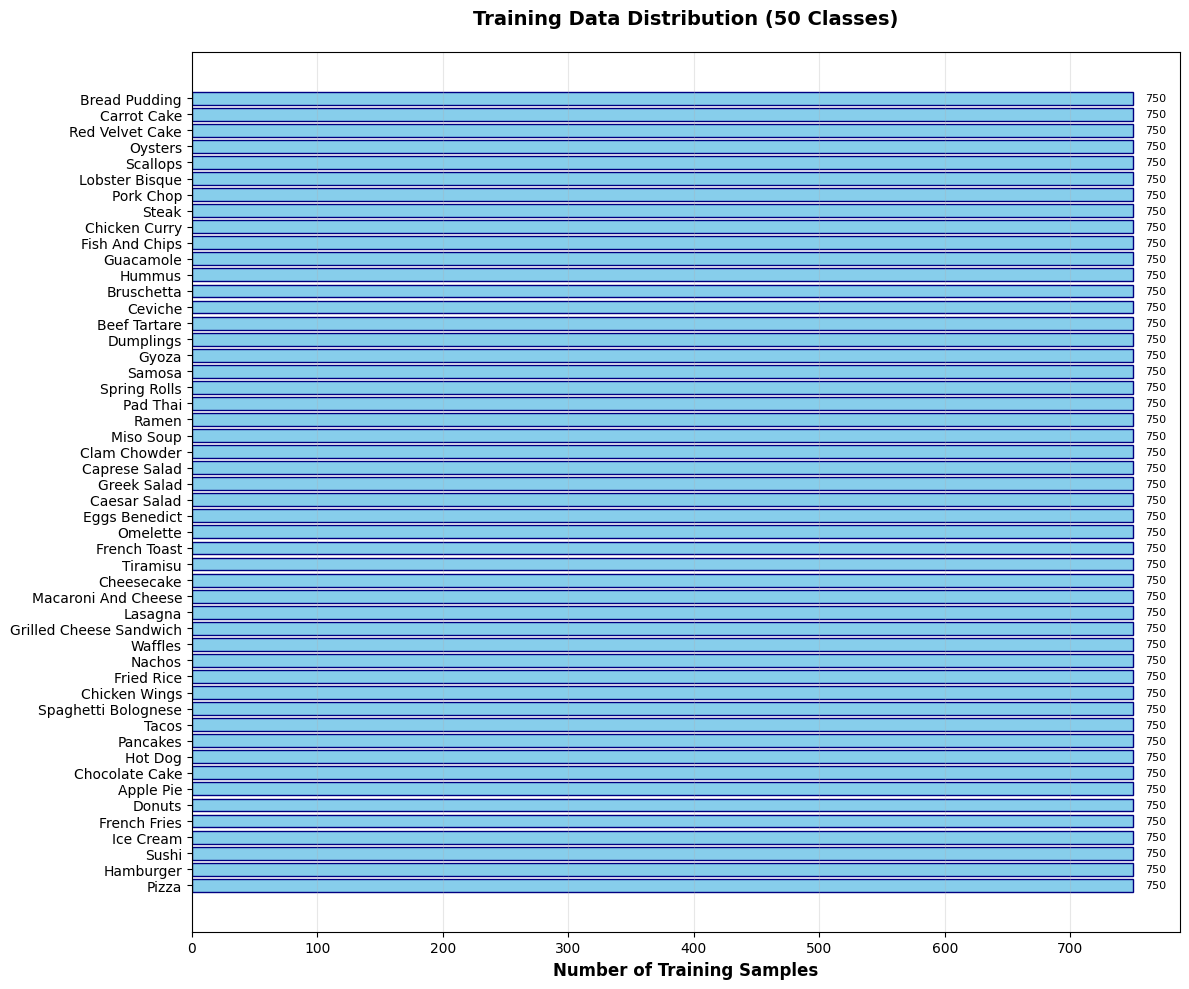

 Displayed and saved

2. Creating sample food images...


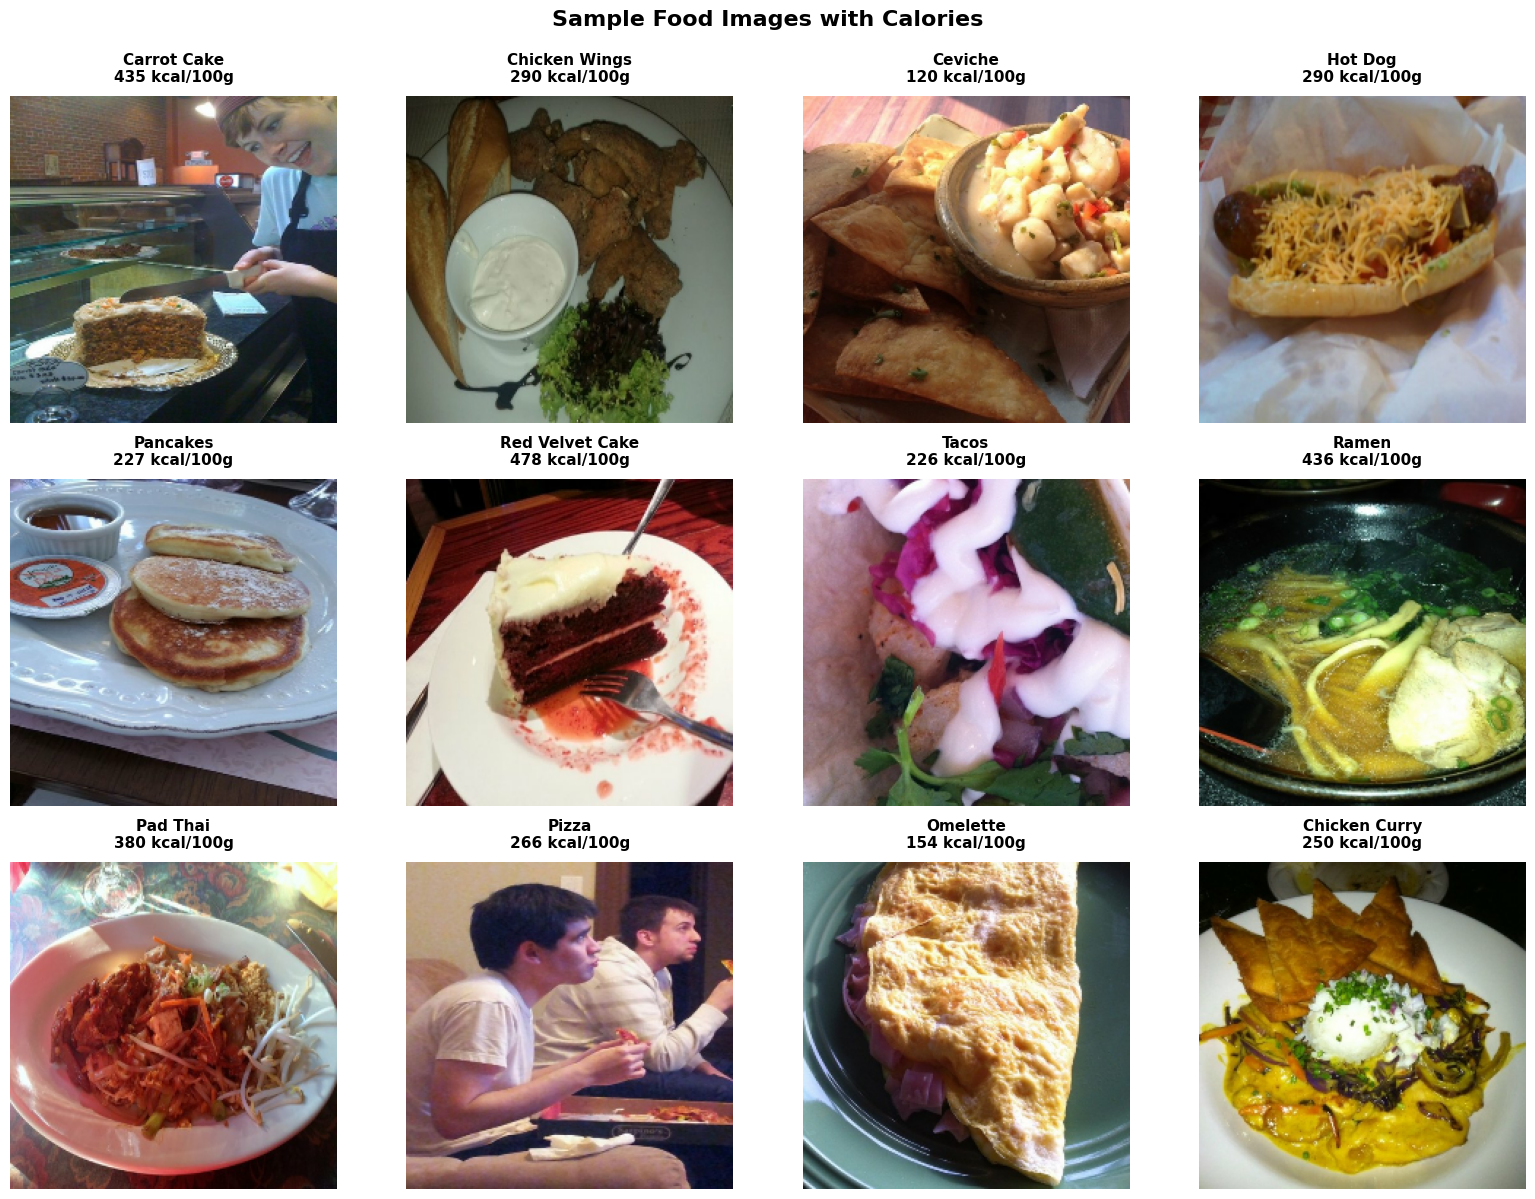

 Displayed and saved



In [ ]:
"""
Data distribution and sample food image visualization.

This section generates:
1. A horizontal bar chart showing the training data distribution
   across all classes.
2. A 3x4 grid of randomly sampled food images with calorie information.

Dependencies:
- matplotlib.pyplot as plt
- random
- collections.Counter
- SELECTED_CLASSES, train_list, test_list, NUTRITION_DB, SAVE_DIR
- get_random_image function
"""

from collections import Counter
import random
import matplotlib.pyplot as plt
from typing import List

# ==============================================================================
# 1. Data Distribution
# ==============================================================================
print("1. Creating data distribution plot...")

# Count how many samples each class has in train and test sets
train_counts = Counter([line.split("/")[0] for line in train_list])
test_counts = Counter([line.split("/")[0] for line in test_list])

# Create horizontal bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Format class names for display (replace underscores, capitalize)
classes_display: List[str] = [c.replace("_", " ").title() for c in SELECTED_CLASSES]
train_values: List[int] = [train_counts[c] for c in SELECTED_CLASSES]

# Plot bars with styling
ax.barh(classes_display, train_values, color="skyblue", edgecolor="navy")
ax.set_xlabel("Number of Training Samples", fontsize=12, fontweight="bold")
ax.set_title(
    "Training Data Distribution (50 Classes)", fontsize=14, fontweight="bold", pad=20
)
ax.grid(axis="x", alpha=0.3)

# Add sample count labels at the end of each bar
for i, v in enumerate(train_values):
    ax.text(v + 10, i, str(v), va="center", fontsize=8)

plt.tight_layout()
plt.savefig(SAVE_DIR / "data_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print(" Displayed and saved\n")


# ==============================================================================
# 2. Sample Images with Calories (3x4 grid)
# ==============================================================================
print("2. Creating sample food images...")

# Create 3x4 grid for 12 sample images
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Randomly select 12 food classes to display
sample_foods: List[str] = random.sample(SELECTED_CLASSES, 12)

for idx, food_class in enumerate(sample_foods):
    img, _ = get_random_image(food_class)

    if img is not None:
        axes[idx].imshow(img)
        nutrition = NUTRITION_DB.get(food_class, {})
        calories = nutrition.get("calories", "?")
        title = f"{food_class.replace('_', ' ').title()}\n{calories} kcal/100g"
        axes[idx].set_title(title, fontsize=11, pad=10, fontweight="bold")

    axes[idx].axis("off")  # Hide axis for cleaner look

plt.suptitle(
    "Sample Food Images with Calories", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.savefig(SAVE_DIR / "sample_foods.png", dpi=150, bbox_inches="tight")
plt.show()
print(" Displayed and saved\n")


3. Creating prediction examples...


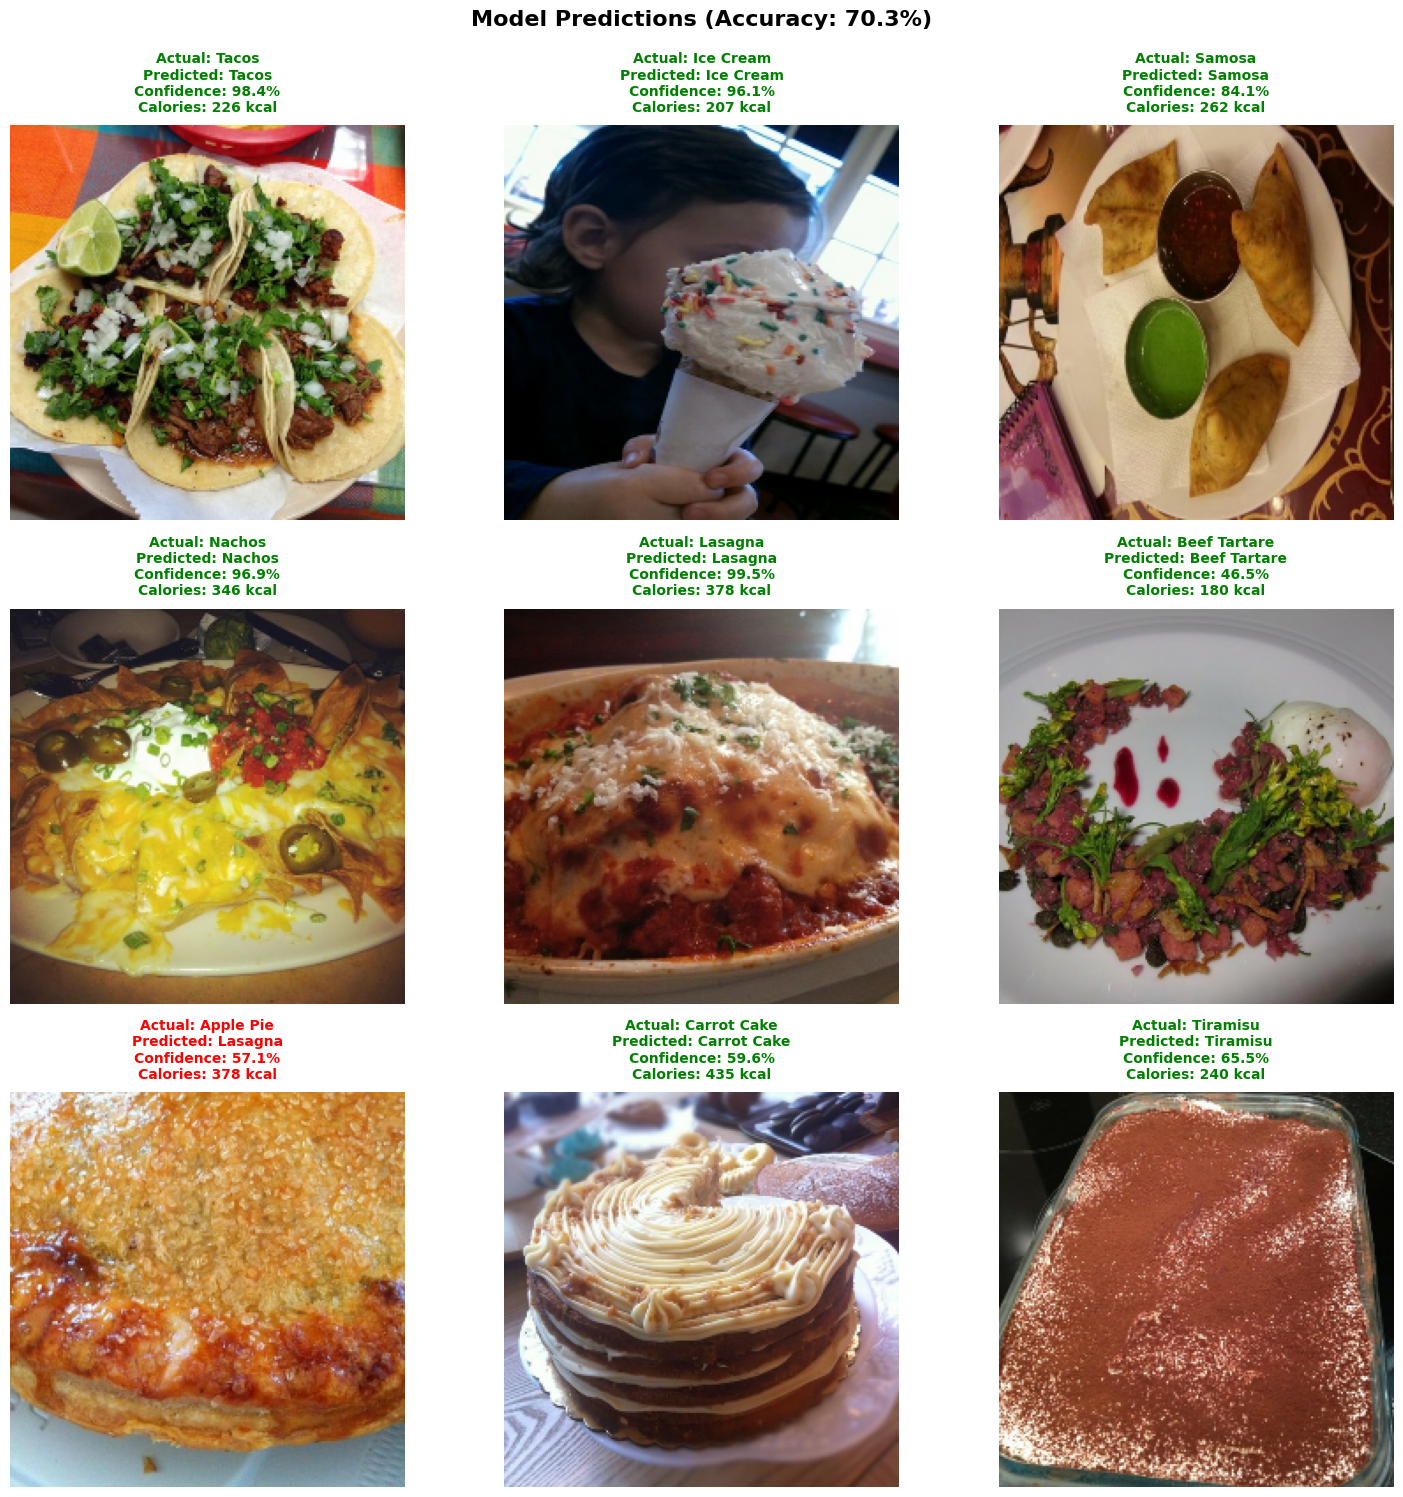

 Displayed and saved

4. Creating detailed prediction example...


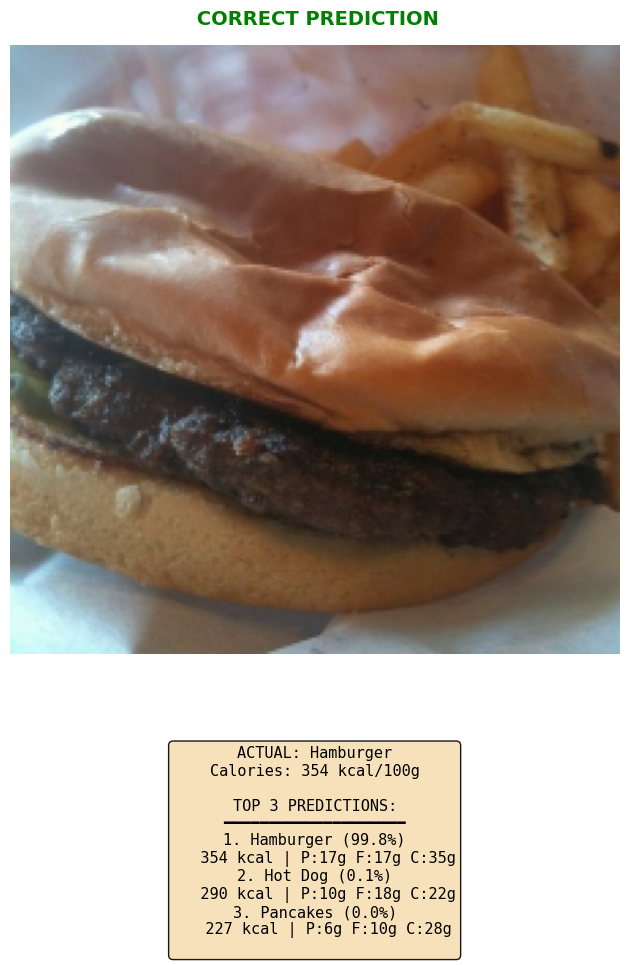

 Displayed and saved

COMPLETE!

Final Model Accuracy: 70.30%

All files saved to: /content/drive/MyDrive/AAI521-Final-Project/outputs

Generated visualizations:
  1. data_distribution.png
  2. sample_foods.png
  3. predictions.png
  4. detailed_prediction.png

Model files:
  - final_model_50class.keras
  - nutrition_database.json


In [ ]:
# ==============================================================================
# 3. Model Predictions with Nutrition
# ==============================================================================
print("3. Creating prediction examples...")

# Create 3x3 grid for 9 prediction examples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Randomly select 9 food classes to test predictions
prediction_foods = random.sample(SELECTED_CLASSES, 9)

for idx, food_class in enumerate(prediction_foods):
    # Get a random image from this class
    img, img_path = get_random_image(food_class)

    if img_path:
        # Make prediction and get nutrition info
        img_display, predictions = predict_food(img_path)

        ax = axes[idx]
        ax.imshow(img_display)

        # Compare actual vs predicted labels
        actual = food_class.replace("_", " ").title()
        pred = predictions[0]

        # Check if prediction is correct and set color accordingly
        is_correct = pred["food_raw"] == food_class
        color = "green" if is_correct else "red"

        # Build title with actual, predicted, confidence, and calories
        title = f"Actual: {actual}\n"
        title += f"Predicted: {pred['food']}\n"
        title += f"Confidence: {pred['confidence']:.1f}%\n"
        title += f"Calories: {pred['calories']} kcal"

        # Color-code title based on prediction correctness
        ax.set_title(title, fontsize=10, color=color, fontweight="bold", pad=10)
        ax.axis("off")

# Get current model accuracy for use in visualizations
results = model.evaluate(test_ds, verbose=0)
loss, accuracy = results

plt.suptitle(
    f"Model Predictions (Accuracy: {accuracy:.1%})",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.savefig(SAVE_DIR / "predictions.png", dpi=150, bbox_inches="tight")
plt.show()
print(" Displayed and saved\n")

# ==============================================================================
# 4. Detailed Prediction with Top-3
# ==============================================================================
print("4. Creating detailed prediction example...")

# Select one random food class for detailed analysis
food_class = random.choice(SELECTED_CLASSES)
img, img_path = get_random_image(food_class)

if img_path:
    # Get predictions with full nutrition data
    img_display, predictions = predict_food(img_path)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img_display)

    actual = food_class.replace("_", " ").title()
    actual_nutrition = NUTRITION_DB.get(food_class, {})

    # Build detailed text showing actual and top-3 predictions
    text = f"ACTUAL: {actual}\n"
    text += f"Calories: {actual_nutrition.get('calories', '?')} kcal/100g\n\n"
    text += "TOP 3 PREDICTIONS:\n"
    text += "━━━━━━━━━━━━━━━━━━━━\n"

    # List top-3 predictions with full nutritional breakdown
    for i, pred in enumerate(predictions, 1):
        text += f"{i}. {pred['food']} ({pred['confidence']:.1f}%)\n"
        text += f"   {pred['calories']} kcal | "
        text += f"P:{pred['protein']}g F:{pred['fat']}g C:{pred['carbs']}g\n"

    is_correct = predictions[0]["food_raw"] == food_class
    color = "green" if is_correct else "red"

    ax.text(
        0.5,
        -0.15,
        text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        horizontalalignment="center",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.9),
        family="monospace",
    )

    ax.set_title(
        " CORRECT PREDICTION" if is_correct else "✗ INCORRECT PREDICTION",
        color=color,
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax.axis("off")

    plt.tight_layout()
    plt.savefig(SAVE_DIR / "detailed_prediction.png", dpi=150, bbox_inches="tight")
    plt.show()
    print(" Displayed and saved\n")

# ==============================================================================
# Summary
# ==============================================================================
print("=" * 60)
print("COMPLETE!")
print("=" * 60)
print(f"\nFinal Model Accuracy: {accuracy:.2%}")
print(f"\nAll files saved to: {SAVE_DIR}")
print("\nGenerated visualizations:")
print("  1. data_distribution.png")
print("  2. sample_foods.png")
print("  3. predictions.png")
print("  4. detailed_prediction.png")
print("\nModel files:")
print("  - final_model_50class.keras")
print("  - nutrition_database.json")
print("=" * 60)


In [ ]:
# ==============================================================================
# Building Second Model EfficientNetB0
# ==============================================================================
print("\n" + "=" * 60)
print("TRAINING SECOND ARCHITECTURE: EfficientNetB0")
print("=" * 60 + "\n")

# --- Build EfficientNetB0 model -----------------------------------------------
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import (
    preprocess_input as efficient_preprocess,
)
import tensorflow as tf
from typing import Tuple

# Create new datasets with EfficientNet preprocessing
def decode_resize_efficient(
    path: tf.Tensor, label: tf.Tensor
) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Decode a JPEG image from a file, resize it, and apply EfficientNetB0 preprocessing.

    Parameters
    ----------
    path : tf.Tensor
        File path tensor pointing to a JPEG image.
    label : tf.Tensor
        Associated label tensor for the image.

    Returns
    -------
    Tuple[tf.Tensor, tf.Tensor]
        A tuple containing:
        - The preprocessed image tensor ready for EfficientNetB0 input.
        - The original label tensor.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = efficient_preprocess(img)
    return img, label



TRAINING SECOND ARCHITECTURE: EfficientNetB0



In [ ]:
"""
EfficientNetB0 Data Pipelines

This section builds the training and test datasets for EfficientNetB0
using TensorFlow `tf.data` pipelines. Images are decoded, resized, and
preprocessed using the EfficientNet preprocessing function.
"""

import tensorflow as tf

# ==============================================================================
# Build training pipeline with EfficientNet preprocessing
# ==============================================================================
train_ds_efficient: tf.data.Dataset = (
    tf.data.Dataset
    .from_tensor_slices((list(train_paths), list(train_labels)))
    .shuffle(len(train_pairs))
    .map(decode_resize_efficient, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
"""
TensorFlow training dataset pipeline.

- Shuffles the dataset using the total number of training pairs.
- Decodes, resizes, and applies EfficientNet preprocessing using `decode_resize_efficient`.
- Batches the data with `BATCH_SIZE`.
- Prefetches batches for performance optimization.
"""

# ==============================================================================
# Build test pipeline with EfficientNet preprocessing
# ==============================================================================
test_ds_efficient: tf.data.Dataset = (
    tf.data.Dataset
    .from_tensor_slices((list(test_paths), list(test_labels)))
    .map(decode_resize_efficient, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
"""
TensorFlow test dataset pipeline.

- Decodes, resizes, and applies EfficientNet preprocessing using `decode_resize_efficient`.
- Batches the data with `BATCH_SIZE`.
- Prefetches batches for performance optimization.
"""


In [ ]:
# ==============================================================================
# Build EfficientNetB0 model with same architecture as MobileNetV2
# ==============================================================================
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

# Define model input
inputs2 = layers.Input(shape=(224, 224, 3))

# Load pre-trained EfficientNetB0 as feature extractor
base2 = EfficientNetB0(include_top=False, weights="imagenet")
base2.trainable = False

# Pass inputs through base model
x2 = base2(inputs2)
x2 = layers.GlobalAveragePooling2D()(x2)

# Add custom classification head (same as MobileNetV2 for fair comparison)
x2 = layers.Dense(512, activation="relu")(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.5)(x2)

x2 = layers.Dense(256, activation="relu")(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.3)(x2)

# Output layer for 50 classes
outputs2 = layers.Dense(50, activation="softmax")(x2)


In [ ]:
# ==============================================================================
# Compile and Train EfficientNetB0 Model
# ==============================================================================
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# Compile model with same settings as MobileNetV2
model2 = keras.Model(inputs2, outputs2)
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("EfficientNetB0 model ready\n")

# Get current model accuracy for use in visualizations
results = model.evaluate(test_ds, verbose=0)
loss, accuracy = results

# Train EfficientNetB0
# Set up checkpoint to save best model
callbacks2 = [
    ModelCheckpoint(
        str(SAVE_DIR / "model_50class_efficientnet.keras"),
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )
]

# Track training time for performance comparison
start_time2 = time.time()

# Train the EfficientNetB0 model
history2 = model2.fit(
    train_ds_efficient,
    validation_data=test_ds_efficient,
    epochs=EPOCHS,
    callbacks=callbacks2,
    verbose=1,
)

training_time2 = time.time() - start_time2

# Get MobileNetV2 accuracy for comparison
# Get final metrics on test set
results2 = model2.evaluate(test_ds_efficient, verbose=0)
loss2, accuracy2 = results2

# Display results
print("\n" + "=" * 60)
print("EFFICIENTNETB0 RESULTS")
print("=" * 60)
print(f"Test Accuracy: {accuracy2:.2%}")
print(f"Test Loss: {loss2:.4f}")
print(f"Training Time: {training_time2 / 60:.2f} minutes\n")

# Save final EfficientNetB0 model for deployment
model2.save(SAVE_DIR / "final_model_50class_efficientnet.keras")


EfficientNetB0 model ready

Epoch 1/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4202 - loss: 2.2846
Epoch 1: val_accuracy improved from -inf to 0.72528, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class_efficientnet.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 67s 39ms/step - accuracy: 0.4203 - loss: 2.2842 - val_accuracy: 0.7253 - val_loss: 0.9383
Epoch 2/20
1168/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6240 - loss: 1.3693
Epoch 2: val_accuracy improved from 0.72528 to 0.74976, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class_efficientnet.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6240 - loss: 1.3692 - val_accuracy: 0.7498 - val_loss: 0.8547
Epoch 3/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6625 - loss: 1.2086
Epoch 3: val_accuracy improved from 0.74976 to 0.75936, saving model to /content/drive/MyDrive/AAI521-Final-Project/outputs/model_50class_efficientnet.k

In [ ]:
"""
Performance Comparison of MobileNetV2 and EfficientNetB0.

This section calculates key performance metrics for both models, including:
- Test accuracy
- Test loss
- Number of parameters
- Training time (in minutes)
- Number of epochs

Results are stored in a JSON file for reference.
"""

# ==============================================================================
# PERFORMANCE COMPARISON
# ==============================================================================
print("\n" + "=" * 60)
print("MODEL COMPARISON ANALYSIS")
print("=" * 60 + "\n")

# Get model sizes (number of trainable parameters)
model1_params = model.count_params()
model2_params = model2.count_params()

# Estimate training time for model 1 (rough estimate from history)
training_time1 = (
    len(history.history["loss"]) * np.mean([history.epoch]) * 30
)  # Rough estimate

# Store comparison data in a dictionary
comparison_data = {
    "MobileNetV2": {
        "accuracy": float(accuracy),
        "loss": float(loss),
        "parameters": int(model1_params),
        "training_time_min": float(training_time1 / 60)
        if "training_time1" in locals()
        else "N/A",
        "epochs": EPOCHS,
    },
    "EfficientNetB0": {
        "accuracy": float(accuracy2),
        "loss": float(loss2),
        "parameters": int(model2_params),
        "training_time_min": float(training_time2 / 60),
        "epochs": EPOCHS,
    },
}

# Save comparison data to JSON file
with open(SAVE_DIR / "model_comparison.json", "w") as f:
    json.dump(comparison_data, f, indent=2)



MODEL COMPARISON ANALYSIS



Creating comparison visualizations...



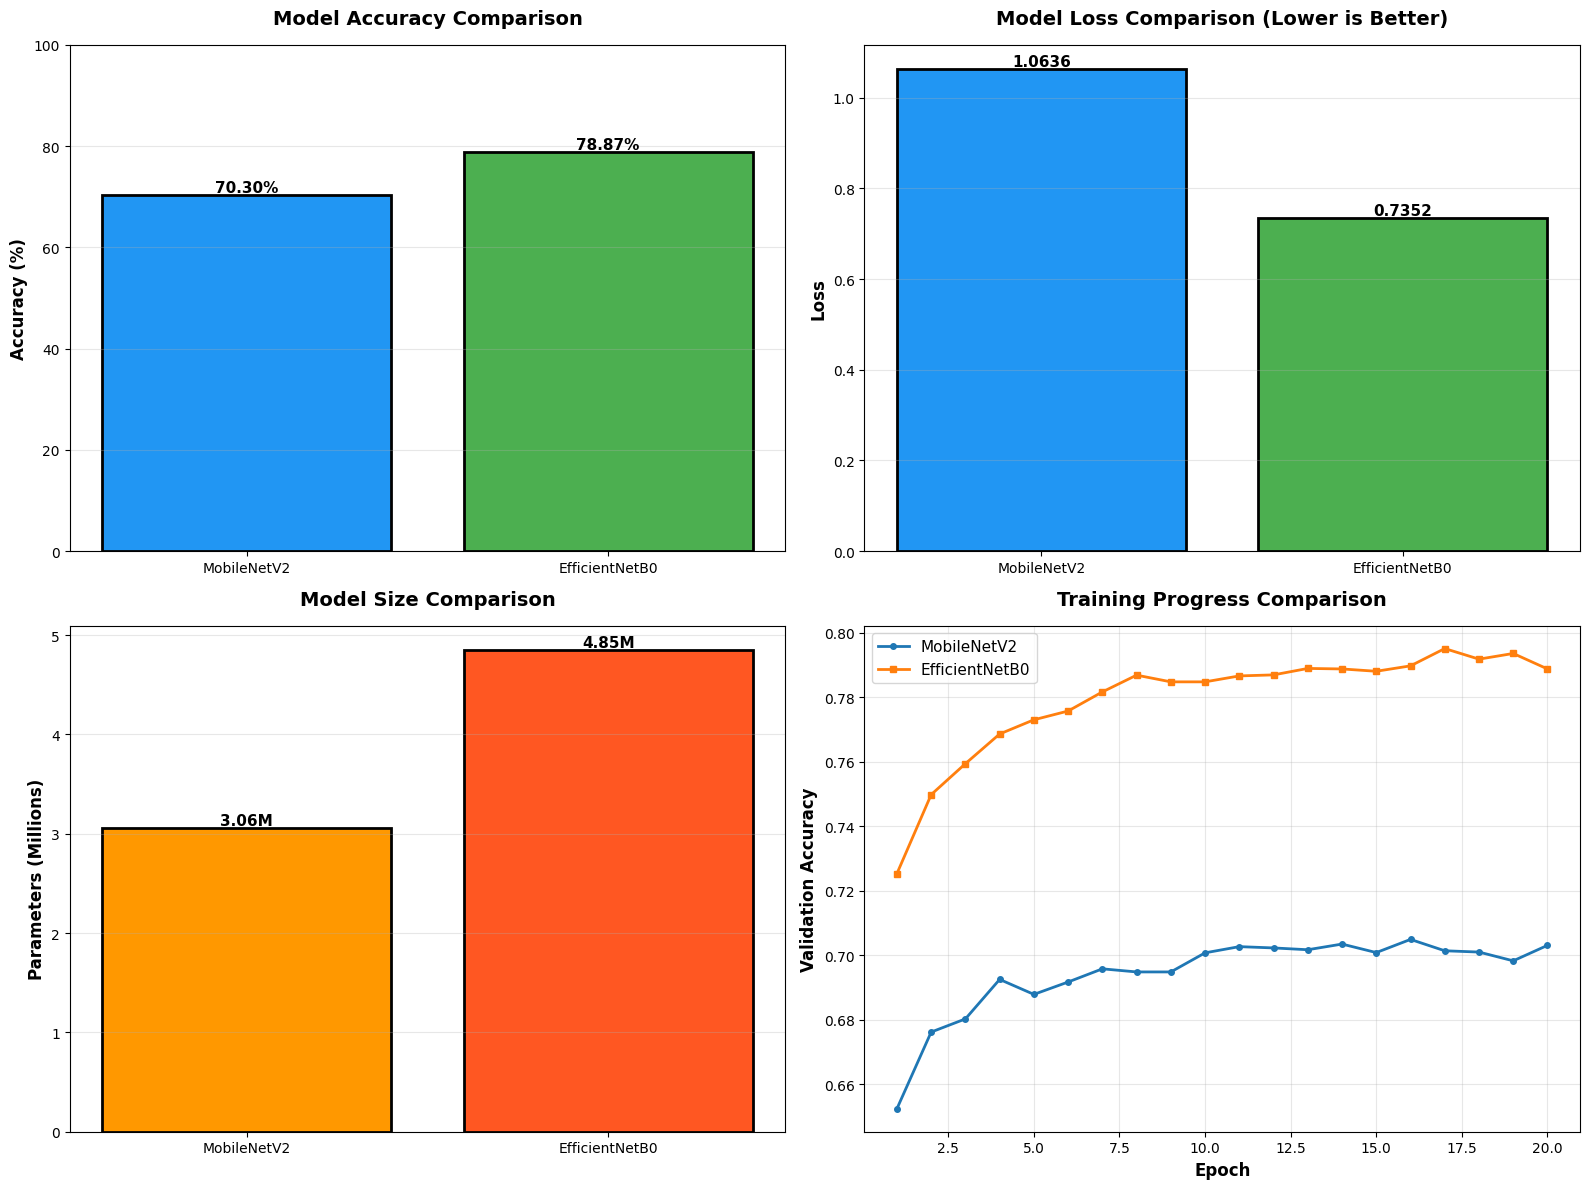

Comparison charts saved



In [ ]:
"""
Visualization 1: Comparison Charts

This section generates a 2x2 grid of visualizations to compare the performance
of MobileNetV2 and EfficientNetB0 models, including:

1. Accuracy Comparison (Bar Chart)
2. Loss Comparison (Bar Chart)
3. Model Parameters Comparison (Bar Chart)
4. Training History Comparison (Line Plot)

Charts are saved as 'model_comparison_charts.png' in the SAVE_DIR.
"""

# ==============================================================================
# VISUALIZATION 1: Comparison Table
# ==============================================================================
print("Creating comparison visualizations...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ------------------------------------------------------------------------------
# 1. Accuracy Comparison (Bar Chart)
# ------------------------------------------------------------------------------
ax1 = axes[0, 0]
models = ["MobileNetV2", "EfficientNetB0"]
accuracies = [accuracy * 100, accuracy2 * 100]
colors = ["#4CAF50" if acc == max(accuracies) else "#2196F3" for acc in accuracies]

bars = ax1.bar(models, accuracies, color=colors, edgecolor="black", linewidth=2)
ax1.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
ax1.set_title("Model Accuracy Comparison", fontsize=14, fontweight="bold", pad=15)
ax1.set_ylim([0, 100])
ax1.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{acc:.2f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# ------------------------------------------------------------------------------
# 2. Loss Comparison (Bar Chart)
# ------------------------------------------------------------------------------
ax2 = axes[0, 1]
losses = [loss, loss2]
colors2 = ["#4CAF50" if l == min(losses) else "#2196F3" for l in losses]

bars2 = ax2.bar(models, losses, color=colors2, edgecolor="black", linewidth=2)
ax2.set_ylabel("Loss", fontsize=12, fontweight="bold")
ax2.set_title("Model Loss Comparison (Lower is Better)", fontsize=14, fontweight="bold", pad=15)
ax2.grid(axis="y", alpha=0.3)

for bar, l in zip(bars2, losses):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{l:.4f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# ------------------------------------------------------------------------------
# 3. Model Parameters Comparison (Bar Chart)
# ------------------------------------------------------------------------------
ax3 = axes[1, 0]
params = [model1_params / 1e6, model2_params / 1e6]  # Convert to millions
colors3 = ["#FF9800", "#FF5722"]

bars3 = ax3.bar(models, params, color=colors3, edgecolor="black", linewidth=2)
ax3.set_ylabel("Parameters (Millions)", fontsize=12, fontweight="bold")
ax3.set_title("Model Size Comparison", fontsize=14, fontweight="bold", pad=15)
ax3.grid(axis="y", alpha=0.3)

for bar, p in zip(bars3, params):
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{p:.2f}M",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# ------------------------------------------------------------------------------
# 4. Training History Comparison (Line Plot)
# ------------------------------------------------------------------------------
ax4 = axes[1, 1]
epochs_range = range(1, EPOCHS + 1)

ax4.plot(
    epochs_range,
    history.history["val_accuracy"],
    label="MobileNetV2",
    linewidth=2,
    marker="o",
    markersize=4,
)
ax4.plot(
    epochs_range,
    history2.history["val_accuracy"],
    label="EfficientNetB0",
    linewidth=2,
    marker="s",
    markersize=4,
)

ax4.set_xlabel("Epoch", fontsize=12, fontweight="bold")
ax4.set_ylabel("Validation Accuracy", fontsize=12, fontweight="bold")
ax4.set_title("Training Progress Comparison", fontsize=14, fontweight="bold", pad=15)
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3)

# Save and display final figure
plt.tight_layout()
plt.savefig(SAVE_DIR / "model_comparison_charts.png", dpi=150, bbox_inches="tight")
plt.show()

print("Comparison charts saved\n")


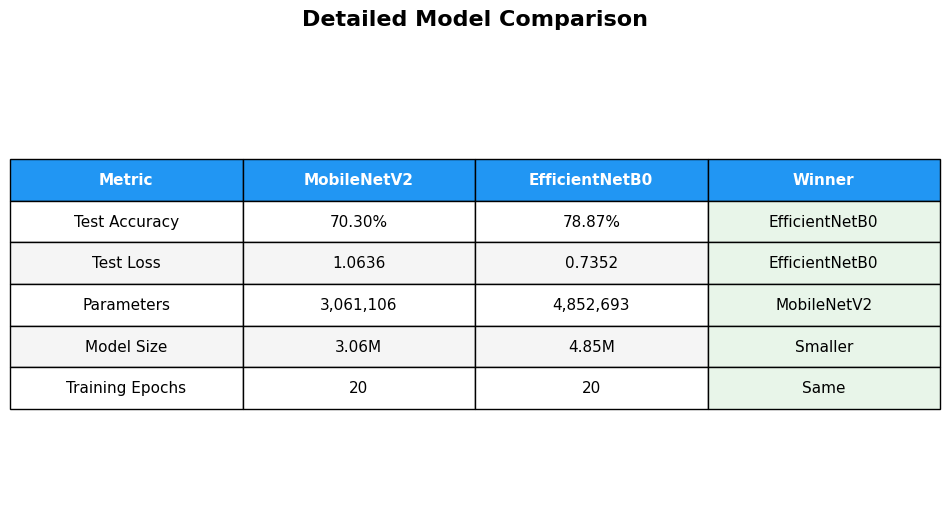

Comparison table saved



In [ ]:
"""
Visualization 2: Detailed Model Comparison Table

This section creates a detailed comparison table between MobileNetV2 and
EfficientNetB0, summarizing the following metrics:

- Test Accuracy
- Test Loss
- Number of Parameters
- Model Size
- Training Epochs

The "Winner" column highlights which model performs better for each metric.
The table is saved as 'comparison_table.png' in the SAVE_DIR.
"""

# ==============================================================================
# VISUALIZATION 2: Detailed Comparison Table
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("tight")
ax.axis("off")

# Create comparison table data
comparison_table = [
    ["Metric", "MobileNetV2", "EfficientNetB0", "Winner"],
    [
        "Test Accuracy",
        f"{accuracy:.2%}",
        f"{accuracy2:.2%}",
        "MobileNetV2" if accuracy > accuracy2 else "EfficientNetB0",
    ],
    [
        "Test Loss",
        f"{loss:.4f}",
        f"{loss2:.4f}",
        "MobileNetV2" if loss < loss2 else "EfficientNetB0",
    ],
    [
        "Parameters",
        f"{model1_params:,}",
        f"{model2_params:,}",
        "MobileNetV2" if model1_params < model2_params else "EfficientNetB0",
    ],
    [
        "Model Size",
        f"{model1_params / 1e6:.2f}M",
        f"{model2_params / 1e6:.2f}M",
        "Smaller" if model1_params < model2_params else "Smaller",
    ],
    ["Training Epochs", str(EPOCHS), str(EPOCHS), "Same"],
]

# Create table in the axes
table = ax.table(
    cellText=comparison_table,
    cellLoc="center",
    loc="center",
    colWidths=[0.25, 0.25, 0.25, 0.25],
)

# Set font size and scale
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor("#2196F3")
    table[(0, i)].set_text_props(weight="bold", color="white")

# Style data rows
for i in range(1, len(comparison_table)):
    for j in range(4):
        if j == 3:  # Winner column
            table[(i, j)].set_facecolor("#E8F5E9")
        else:
            table[(i, j)].set_facecolor("#F5F5F5" if i % 2 == 0 else "white")

# Add title
plt.title("Detailed Model Comparison", fontsize=16, fontweight="bold", pad=20)

# Save and display the figure
plt.savefig(SAVE_DIR / "comparison_table.png", dpi=150, bbox_inches="tight")
plt.show()

print("Comparison table saved\n")


Creating side-by-side prediction comparison...



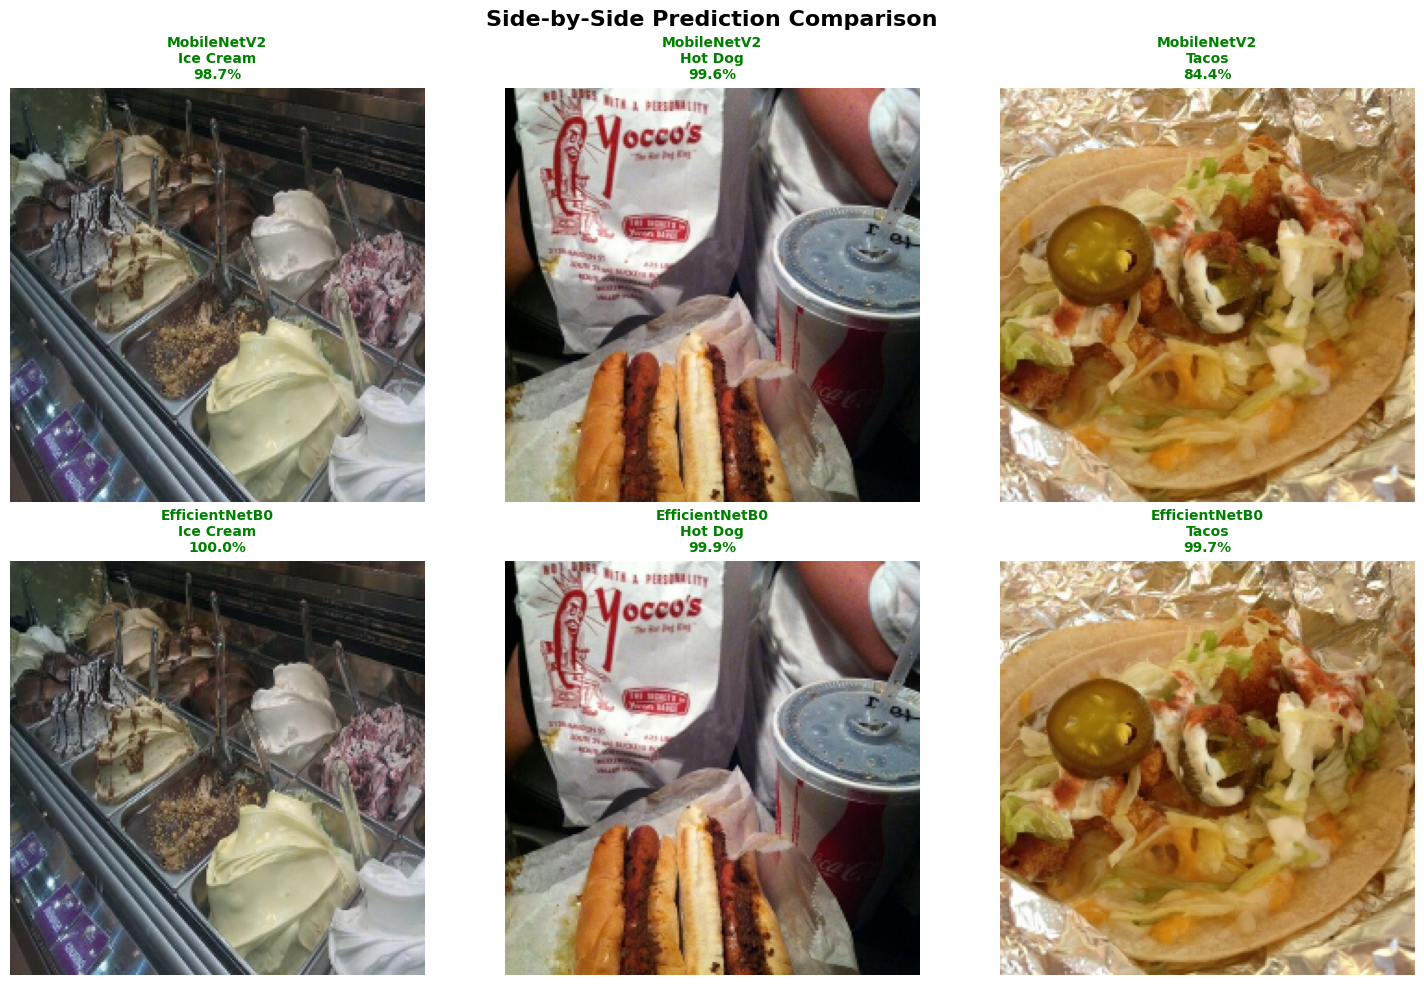

Prediction comparison saved



In [ ]:
# ==============================================================================
# VISUALIZATION 3: Side-by-Side Predictions
# ==============================================================================
print("Creating side-by-side prediction comparison...\n")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Test both models on same images
test_foods = random.sample(SELECTED_CLASSES, 3)

for idx, food_class in enumerate(test_foods):
    # Get random image
    class_dir = IMAGES_DIR / food_class
    images = list(class_dir.glob("*.jpg"))
    if images:
        img_path = random.choice(images)

        # Load image for display
        img = tf.io.read_file(str(img_path))
        img_raw = tf.image.decode_jpeg(img, channels=3)
        img_display = tf.image.resize(img_raw, (224, 224)).numpy().astype("uint8")

        # Predict with MobileNetV2
        img1 = tf.image.resize(img_raw, IMG_SIZE)
        img1 = preprocess_input(img1)
        img1 = tf.expand_dims(img1, 0)
        pred1 = model.predict(img1, verbose=0)[0]
        top1_idx = np.argmax(pred1)
        top1_conf = pred1[top1_idx] * 100
        top1_class = SELECTED_CLASSES[top1_idx]

        # Predict with EfficientNetB0
        img2 = tf.image.resize(img_raw, IMG_SIZE)
        img2 = efficient_preprocess(img2)
        img2 = tf.expand_dims(img2, 0)
        pred2 = model2.predict(img2, verbose=0)[0]
        top2_idx = np.argmax(pred2)
        top2_conf = pred2[top2_idx] * 100
        top2_class = SELECTED_CLASSES[top2_idx]

        # Plot MobileNetV2 prediction
        ax1 = axes[0, idx]
        ax1.imshow(img_display)
        correct1 = top1_class == food_class
        color1 = "green" if correct1 else "red"
        title1 = f"MobileNetV2\n{top1_class.replace('_', ' ').title()}\n{top1_conf:.1f}%"
        ax1.set_title(title1, fontsize=10, color=color1, fontweight="bold")
        ax1.axis("off")

        # Plot EfficientNetB0 prediction
        ax2 = axes[1, idx]
        ax2.imshow(img_display)
        correct2 = top2_class == food_class
        color2 = "green" if correct2 else "red"
        title2 = f"EfficientNetB0\n{top2_class.replace('_', ' ').title()}\n{top2_conf:.1f}%"
        ax2.set_title(title2, fontsize=10, color=color2, fontweight="bold")
        ax2.axis("off")

# Add model labels on the left
axes[0, 0].set_ylabel(
    "MobileNetV2", fontsize=12, fontweight="bold", rotation=0, labelpad=50
)
axes[1, 0].set_ylabel(
    "EfficientNetB0", fontsize=12, fontweight="bold", rotation=0, labelpad=50
)

plt.suptitle("Side-by-Side Prediction Comparison", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(SAVE_DIR / "predictions_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("Prediction comparison saved\n")


In [ ]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("="*60)
print("COMPARISON COMPLETE!")
print("="*60)
print(f"\nMobileNetV2:")
print(f"  Accuracy: {accuracy:.2%}")
print(f"  Loss: {loss:.4f}")
print(f"  Parameters: {model1_params:,}")

print(f"\nEfficientNetB0:")
print(f"  Accuracy: {accuracy2:.2%}")
print(f"  Loss: {loss2:.4f}")
print(f"  Parameters: {model2_params:,}")

# Determine winner
if accuracy > accuracy2:
    winner = "MobileNetV2"
    margin = (accuracy - accuracy2) * 100
else:
    winner = "EfficientNetB0"
    margin = (accuracy2 - accuracy) * 100

print(f"\nWINNER: {winner}")
print(f"   Accuracy advantage: {margin:.2f} percentage points")

print(f"\nAll comparison files saved to: {SAVE_DIR}")
print("  - model_comparison.json")
print("  - model_comparison_charts.png")
print("  - comparison_table.png")
print("  - predictions_comparison.png")
print("  - final_model_50class_efficientnet.keras")
print("="*60)

COMPARISON COMPLETE!

MobileNetV2:
  Accuracy: 70.30%
  Loss: 1.0636
  Parameters: 3,061,106

EfficientNetB0:
  Accuracy: 78.87%
  Loss: 0.7352
  Parameters: 4,852,693

WINNER: EfficientNetB0
   Accuracy advantage: 8.57 percentage points

All comparison files saved to: /content/drive/MyDrive/AAI521-Final-Project/outputs
  - model_comparison.json
  - model_comparison_charts.png
  - comparison_table.png
  - predictions_comparison.png
  - final_model_50class_efficientnet.keras
